# 1. Importing Packages

In [112]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy import stats
import statsmodels.api as sm

# 2. DATA CLEANING AND PREPARATION

## 2.1 Human Development Index (HDI)

### 2.1.1 Data Loading and Exploration

In [113]:
# Loading the HDI data
hdi_df = pd.read_csv('data/HDR21-22_Composite_indices_complete_time_series.csv')
hdi_df.sample(3)

,iso3,country,hdicode,region,hdi_rank_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,...,mf_2012,mf_2013,mf_2014,mf_2015,mf_2016,mf_2017,mf_2018,mf_2019,mf_2020,mf_2021
76,HUN,Hungary,Very High,NaN,46.0,0.720,0.715,0.714,0.722,0.731,...,11.92,13.24,14.93,13.55,13.92,13.85,14.75,15.27,15.27,15.27
156,SLV,El Salvador,Medium,LAC,125.0,0.525,0.536,0.548,0.558,0.568,...,8.11,8.07,8.05,8.50,8.08,7.89,5.93,5.87,5.87,5.87
29,CAN,Canada,Very High,NaN,15.0,0.860,0.864,0.868,0.866,0.872,...,34.83,35.00,33.82,34.42,35.46,36.48,35.84,35.05,35.05,35.05


In [114]:
# Exploring the columns
print(hdi_df.columns.tolist(), end=", ")

['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2021', 'hdi_1990', 'hdi_1991', 'hdi_1992', 'hdi_1993', 'hdi_1994', 'hdi_1995', 'hdi_1996', 'hdi_1997', 'hdi_1998', 'hdi_1999', 'hdi_2000', 'hdi_2001', 'hdi_2002', 'hdi_2003', 'hdi_2004', 'hdi_2005', 'hdi_2006', 'hdi_2007', 'hdi_2008', 'hdi_2009', 'hdi_2010', 'hdi_2011', 'hdi_2012', 'hdi_2013', 'hdi_2014', 'hdi_2015', 'hdi_2016', 'hdi_2017', 'hdi_2018', 'hdi_2019', 'hdi_2020', 'hdi_2021', 'le_1990', 'le_1991', 'le_1992', 'le_1993', 'le_1994', 'le_1995', 'le_1996', 'le_1997', 'le_1998', 'le_1999', 'le_2000', 'le_2001', 'le_2002', 'le_2003', 'le_2004', 'le_2005', 'le_2006', 'le_2007', 'le_2008', 'le_2009', 'le_2010', 'le_2011', 'le_2012', 'le_2013', 'le_2014', 'le_2015', 'le_2016', 'le_2017', 'le_2018', 'le_2019', 'le_2020', 'le_2021', 'eys_1990', 'eys_1991', 'eys_1992', 'eys_1993', 'eys_1994', 'eys_1995', 'eys_1996', 'eys_1997', 'eys_1998', 'eys_1999', 'eys_2000', 'eys_2001', 'eys_2002', 'eys_2003', 'eys_2004', 'eys_2005', 'eys_2006', 'e

In [115]:
# Selecting the columns of interest
hdi_df = hdi_df[['country', 'hdicode', 'hdi_2021', 'region']]
hdi_df.head()

,country,hdicode,hdi_2021,region
0,Afghanistan,Low,0.478,SA
1,Angola,Medium,0.586,SSA
2,Albania,High,0.796,ECA
3,Andorra,Very High,0.858,NaN
4,United Arab Emirates,Very High,0.911,AS


In [116]:
# Renaming the columns so that they are easier to understand 
hdi_df.rename(columns={'hdi_2021': 'HDI',
                       'country': 'Country',
                       'hdicode': 'HDI Group',
                       'region': 'Region'}, inplace=True)    

### 2.1.2 Data Cleaning

In [117]:
hdi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    206 non-null    object 
 1   HDI Group  191 non-null    object 
 2   HDI        202 non-null    float64
 3   Region     151 non-null    object 
dtypes: float64(1), object(3)
memory usage: 6.6+ KB


Lets look at the null values

In [118]:
# Looking at the rows with missing HDI values
hdi_df[hdi_df['HDI'].isnull()]

,Country,HDI Group,HDI,Region
108,Monaco,NaN,NaN,NaN
132,Nauru,NaN,NaN,EAP
142,Korea (Democratic People's Rep. of),NaN,NaN,EAP
158,Somalia,NaN,NaN,AS


We can drop these rows as they contain no real information

In [119]:
# Dropping values which have NaN HDI values while ignoring region
hdi_df.dropna(subset=['HDI'], inplace=True)

In [120]:
hdi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, 0 to 205
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    202 non-null    object 
 1   HDI Group  191 non-null    object 
 2   HDI        202 non-null    float64
 3   Region     148 non-null    object 
dtypes: float64(1), object(3)
memory usage: 7.9+ KB


We ignore the region column as we will need it to conduct regional-level analysis and we will manually assign regions to where it is missing.

In [121]:
# Getting the regions (abbreviations)
hdi_df['Region'].value_counts()  

Region
SSA    46
LAC    33
EAP    24
AS     19
ECA    17
SA      9
Name: count, dtype: int64

As we can see we have 4 countries with missing HDI scores. These will have to be dropped as there would be no way to fill in the data for these cells (one could try to look for other datasets). We can also observe that there are summaries of the HDI scores by region and by HDI Group. As we will drop some countries at merging at assigning some to new regions these scores will become inaccurate.

In [122]:
hdi_df_regions = hdi_df.tail(11)
hdi_df_regions

,Country,HDI Group,HDI,Region
195,Very high human development,NaN,0.896,NaN
196,High human development,NaN,0.754,NaN
197,Medium human development,NaN,0.636,NaN
198,Low human development,NaN,0.518,NaN
199,Arab States,NaN,0.708,NaN
200,East Asia and the Pacific,NaN,0.749,NaN
201,Europe and Central Asia,NaN,0.796,NaN
202,Latin America and the Caribbean,NaN,0.754,NaN
203,South Asia,NaN,0.632,NaN
204,Sub-Saharan Africa,NaN,0.547,NaN


Here we drop these rows (they are the last 11 rows of the dataset)

In [123]:
hdi_df = hdi_df.drop(hdi_df.tail(11).index)
hdi_df.tail()

,Country,HDI Group,HDI,Region
190,Samoa,High,0.707,EAP
191,Yemen,Low,0.455,AS
192,South Africa,High,0.713,SSA
193,Zambia,Medium,0.565,SSA
194,Zimbabwe,Medium,0.593,SSA


In [124]:
hdi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 194
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    191 non-null    object 
 1   HDI Group  191 non-null    object 
 2   HDI        191 non-null    float64
 3   Region     148 non-null    object 
dtypes: float64(1), object(3)
memory usage: 7.5+ KB


In [125]:
hdi_df.describe()

,HDI
count,191.000000
mean,0.720576
std,0.150661
min,0.385000
25%,0.599500
50%,0.739000
75%,0.835000
max,0.962000


We do not observe any weird behavior when looking at the above statistics.

In [126]:
# Checking for duplicated rows
duplicated_rows = hdi_df[hdi_df.duplicated()]
duplicated_rows

,Country,HDI Group,HDI,Region


We do not have duplicate rows, thus we do not need to worry about them.

In [127]:
# Checking for nan values in the columns
hdi_df.isna().sum(axis=0)

Country       0
HDI Group     0
HDI           0
Region       43
dtype: int64

The only NaN values are now in the 'Region' column but we will handle them.

In [128]:
# Getting all the unique regions
hdi_df['Region'].unique()

array(['SA', 'SSA', 'ECA', nan, 'AS', 'LAC', 'EAP'], dtype=object)

In [129]:
# Checking which rows don't have a region assigned to them
no_region = hdi_df[hdi_df['Region'].isna()]
no_region.head(5)

,Country,HDI Group,HDI,Region
3,Andorra,Very High,0.858,NaN
8,Australia,Very High,0.951,NaN
9,Austria,Very High,0.916,NaN
12,Belgium,Very High,0.937,NaN
16,Bulgaria,High,0.795,NaN


In [130]:
# Checking the countries which have no regions
no_region = hdi_df.loc[hdi_df['Region'].isna(), 'Country'].tolist()

In [131]:
# Creating Americas region (renamed LAC to AME so that USA and Canada can be included)
hdi_df.loc[hdi_df['Region'] == 'LAC', 'Region'] = 'AME'

In [132]:
# Assigning a region (ECA) to the European countries 
region_to_assign = 'ECA'
country = ['Andorra','Austria','Belgium','Bulgaria','Switzerland','Cyprus','Czechia','Germany','Denmark','Spain','Estonia','Finland','France','United Kingdom','Greece','Croatia',
          'Hungary','Ireland','Iceland','Israel','Italy','Liechtenstein','Lithuania','Luxembourg','Latvia','Monaco','Malta','Netherlands','Norway','New Zealand','Poland',
          'Portugal','Romania','Russian Federation','San Marino','Slovakia','Slovenia','Sweden']
mask = hdi_df['Country'].isin(country)
hdi_df.loc[mask, 'Region'] = region_to_assign

# Assigning a region (AME) to the American countries
region_to_assign = 'AME'
country = ['Canada', 'United States']
mask = hdi_df['Country'].isin(country)
hdi_df.loc[mask, 'Region'] = region_to_assign

# Assigning a region (EAP) to the Asian countries
region_to_assign = 'EAP'
country = ['Australia', 'Hong Kong, China (SAR)', 'Japan', 'Korea (Republic of)']
mask = hdi_df['Country'].isin(country)
hdi_df.loc[mask, 'Region'] = region_to_assign

In [133]:
# Sorting the countries by the HDI
hdi_df.sort_values(by=['HDI'], ascending=False)

,Country,HDI Group,HDI,Region
30,Switzerland,Very High,0.962,ECA
130,Norway,Very High,0.961,ECA
82,Iceland,Very High,0.959,ECA
72,"Hong Kong, China (SAR)",Very High,0.952,EAP
8,Australia,Very High,0.951,EAP
...,...,...,...,...
11,Burundi,Low,0.426,SSA
28,Central African Republic,Low,0.404,SSA
126,Niger,Low,0.400,SSA
169,Chad,Low,0.394,SSA


In [134]:
# Setting the country column as the index
hdi_df.set_index('Country',inplace=True)

## 2.2 IQ

### 2.2.1 Data Loading and Exploration

In [135]:
# Loading the IQ data
iq_df = pd.read_csv('data/National_IQ.csv')
iq_df.sample(3)

,Rank,Country,Measured IQ,IQ data quality,SchAch,SA direct,SA scaled,SA data quality,Final IQ,Final IQ.1
143,144.0,Jamaica,71.0,11.0,NaN,NaN,NaN,NaN,71,71.0
66,66.0,Suriname,89.0,4.0,NaN,NaN,NaN,NaN,89,89.0
92,91.0,New Caledonia,85.0,2.0,NaN,NaN,NaN,NaN,85,85.0


In [136]:
iq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rank             162 non-null    float64
 1   Country          204 non-null    object 
 2   Measured IQ      136 non-null    float64
 3   IQ data quality  137 non-null    float64
 4    SchAch          113 non-null    float64
 5   SA direct        111 non-null    float64
 6   SA scaled        112 non-null    float64
 7   SA data quality  112 non-null    float64
 8    Final IQ        204 non-null    object 
 9    Final IQ.1      204 non-null    float64
dtypes: float64(8), object(2)
memory usage: 16.1+ KB


The values which we are intersted in are ones which are easily interpretable, and relevant to the research question, which aim it is to compare the HDI scores with the IQ scores. To do this, the IQ of the country and the country itself ought to be included. 

In [137]:
iq_df.columns

Index(['Rank', 'Country', 'Measured IQ', 'IQ data quality', ' SchAch',
       'SA direct', 'SA scaled', 'SA data quality', ' Final IQ',
       ' Final IQ.1'],
      dtype='object')

In [138]:
# Selecting the columns of interest
columns_of_interest = ['Country', ' Final IQ']
iq_df = iq_df[columns_of_interest]

In [139]:
# Renaming these columns
iq_df = iq_df.rename(columns=
{' Final IQ': 'IQ',
})

### 2.1.2 Data Cleaning

Since we are searching for potential biases and other correlations between the variables it is crucial that we do not have missing values. Because of this, along with the same methodlogy being applied for the HDI dataset, we have to drop the NaN values rows of the IQ column. 

In [140]:
iq_df[iq_df['IQ'].isnull()]

,Country,IQ


As we do not have null values in the IQ column we do not need to drop anything (regarding that metric)

In [141]:
iq_df

,Country,IQ
0,Singapore,107.1
1,China,105.8
2,Hong Kong,105.7
3,Korea: South,104.6
4,Taiwan,104.6
...,...,...
199,GuineaBissau,(69)
200,Liberia,(68)
201,Haiti,(67)
202,Sao Tome & Principe,(67)


The values in brackets are estimated from the neighbouring countries

In [142]:
# Checking for duplicated rows
iq_df[iq_df.duplicated]

,Country,IQ


In [143]:
# The IQ values which are in parentheses were estimated from their neighbouring countries
iq_values_estimated = iq_df[iq_df['IQ'].astype(str).str.contains(r'\(\d+\)')]
iq_values_estimated.head(10)

,Country,IQ
163,Andorra,(97)
164,Belarus,(95)
165,Cambodia,(92)
166,Brunei,(89)
167,St Helena,(86)
168,EastTimor,(85)
169,Kiribati,(85)
170,Myanmar/Burma,(85)
171,Bahamas,(84)
172,Micronesia,(84)


In [144]:
# Number of countries where the IQ was estimated from the neighbouring countries
len(iq_values_estimated)

41

For the sake of this analysis we will treat these scores as actual IQ scores to conduct a meaningful research with a sufficient amount of countries. We understand that this might cause certain biases. Coming up with a better estimation method would be beyond the scope of this project and we could not find another dataset containing these scores.

In [145]:
# We will keep these values to have enough countries which have an iq value
iq_df['IQ'] = iq_df['IQ'].str.replace('(', '').str.replace(')', '').astype(float)

In [146]:
# Sorting the countries by the HDI
iq_df.sort_values(by=['IQ'], ascending=False)

,Country,IQ
0,Singapore,107.1
1,China,105.8
2,Hong Kong,105.7
3,Korea: South,104.6
4,Taiwan,104.6
...,...,...
157,Central African Rep.,64.0
156,Cameroon,64.0
160,St Lucia,62.0
159,Gambia,62.0


In [147]:
# Sorting the countries by the IQ
iq_df.set_index('Country',inplace=True)

## 2.3 Data Merging

In [148]:
# First outer join the two dataframes to see which countries are missing from 
# the other dataframe and to filter at those which are represented by different names
outer_join_df = hdi_df.merge(iq_df, how='outer',on='Country')
outer_join_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, Afghanistan to Sao Tome & Principe
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HDI Group  191 non-null    object 
 1   HDI        191 non-null    float64
 2   Region     191 non-null    object 
 3   IQ         204 non-null    float64
dtypes: float64(2), object(2)
memory usage: 9.6+ KB


In [149]:
# Looking at which countries seem to be missing from the other dataframes
missing_in_hdi = outer_join_df[outer_join_df['HDI'].isnull()].index
missing_in_hdi = sorted(missing_in_hdi.tolist())
print("In IQ but missing in HDI: \n", missing_in_hdi)

missing_in_IQ = outer_join_df[outer_join_df['IQ'].isnull()].index
missing_in_IQ = sorted(missing_in_IQ.tolist())
print('In HDI but missing in IQ: \n', missing_in_IQ)


In IQ but missing in HDI: 
 ['(Serbia &) Montenegro', 'Antigua/Barbuda', 'Bermuda', 'Bolivia', 'Bosnia', 'Brunei', 'Cape Verde', 'Central African Rep.', 'Congo (Brazzaville)', 'Congo (Zaire)', 'Cook Islands', 'CostaRica', "Cote d'Ivoire", 'CzechRep.', 'EastTimor', 'England', 'Greenland', 'GuineaBissau', 'Hong Kong', 'Iran', 'Korea: North', 'Korea: South', 'Laos', 'Macao', 'Macedonia', 'Mariana Islands', 'Micronesia', 'Moldova', 'Myanmar/Burma', 'Netherlands Antilles', 'New Caledonia', 'Palestine', 'Papua N.G.', 'Puerto Rico', 'Russia', 'Samoa (Western)', 'Sao Tome & Principe', 'Scotland', 'Serbia & (Montenegro)', 'Somalia', 'St  Helena', 'St Kitts & Nevis', 'St Lucia', 'St Vincent', 'Swaziland', 'Syria', 'Taiwan', 'Tanzania', 'Tibet', 'Trinidad & Tobago', 'USA', 'Venezuela', 'Vietnam', 'Zanzibar']
In HDI but missing in IQ: 
 ['Antigua and Barbuda', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Brunei Darussalam', 'Cabo Verde', 'Central African Republic', 'Congo', 'Cong

A few countries on the list seem to have data from both data sets, but are named differently, which makes for the large amount of values (252)

In [150]:
# We rename these countries so that their names match
iq_renaming = {
'(Serbia &) Montenegro' : 'Montenegro',
'Central African Rep.' : 'Central African Republic',
'CostaRica' : 'Costa Rica',
'GuineaBissau' : 'Guinea-Bissau',
'Myanmar/Burma' : 'Myanmar',
'Papua N.G.' : 'Papua New Guinea',
'CzechRep.' : 'Czechia',
'Macedonia' : 'North Macedonia',
'Antigua/Barbuda' : 'Antigua and Barbuda',
'Sao Tome & Principe' : 'Sao Tome and Principe',
'Serbia & (Montenegro)' : 'Serbia',
'Samoa (Western)' : 'Samoa',
'St Lucia' : 'Saint Lucia',
'Tanzania (United Republic of)' : 'Tanzania',
'Trinidad & Tobago' : 'Trinidad and Tobago',
}

hdi_renaming = {
    'Bolivia (Plurinational State of)' : 'Bolivia',
    'Bosnia and Herzegovina': 'Bosnia',
    'Brunei Darussalam' : 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'Congo' : 'Congo (Brazzaville)',
    'Congo (Democratic Republic of the)' : 'Congo (Zaire)',
    'Hong Kong, China (SAR)' : 'Hong Kong',
    'Iran (Islamic Republic of)' : 'Iran', 
    "Lao People's Democratic Republic" : 'Laos',
    'Moldova (Republic of)' : 'Moldova',
    'Palestine, State of' : 'Palestine',
    'Russian Federation': 'Russia',
    "Côte d'Ivoire": "Cote d'Ivoire",
    'Korea (Republic of)' : 'Korea: South',
    'Syrian Arab Republic' : 'Syria',
    'Viet Nam' : 'Vietnam',
    'Venezuela (Bolivarian Republic of)' : 'Venezuela',
    'Tanzania (United Republic of)' : 'Tanzania',
    'Saint Vincent and the Grenadines' : 'St Vincent'

}
iq_df = iq_df.rename(index = iq_renaming)
hdi_df = hdi_df.rename(index = hdi_renaming)

In [151]:
# Looking at the missing values to avoid the case where two countries 
# are the same but have completely different names
outer_join_df = hdi_df.merge(iq_df, how='outer',on='Country')
missing_in_hdi = outer_join_df[outer_join_df['HDI'].isnull()].index
missing_in_hdi = sorted(missing_in_hdi.tolist())
print("In IQ but missing in HDI: \n", missing_in_hdi)

missing_in_IQ = outer_join_df[outer_join_df['IQ'].isnull()].index
missing_in_IQ = sorted(missing_in_IQ.tolist())
print('In HDI but missing in IQ: \n', missing_in_IQ)

In IQ but missing in HDI: 
 ['Bermuda', 'Cook Islands', 'EastTimor', 'England', 'Greenland', 'Korea: North', 'Macao', 'Mariana Islands', 'Micronesia', 'Netherlands Antilles', 'New Caledonia', 'Puerto Rico', 'Scotland', 'Somalia', 'St  Helena', 'St Kitts & Nevis', 'Swaziland', 'Taiwan', 'Tibet', 'USA', 'Zanzibar']
In HDI but missing in IQ: 
 ['Eswatini (Kingdom of)', 'Micronesia (Federated States of)', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'South Sudan', 'Timor-Leste', 'Tuvalu', 'United States']


In [152]:
# Renaming the countries which have completely different names in the two dataframes
iq_renamed_indexes = {
    'USA': 'United States',
    'Swaziland': 'Eswatini',
    'EastTimor': 'East Timor',
    'St Kitts & Nevis': 'Saint Kitts and Nevis',
} 

hdi_renamed_indexes = {
    'Eswatini (Kingdom of)': 'Eswatini',
    'Micronesia (Federated States of)': 'Micronesia',
    'Timor-Leste': 'East Timor'
}

iq_df = iq_df.rename(index = iq_renamed_indexes)
hdi_df = hdi_df.rename(index = hdi_renamed_indexes)

# Looking at the two dataframes again
outer_join_df = hdi_df.merge(iq_df, how='outer',on='Country')
missing_in_hdi = outer_join_df[outer_join_df['HDI'].isnull()].index
missing_in_hdi = sorted(missing_in_hdi.tolist())
print("In IQ but missing in HDI: \n", missing_in_hdi)

missing_in_IQ = outer_join_df[outer_join_df['IQ'].isnull()].index
missing_in_IQ = sorted(missing_in_IQ.tolist())
print('In HDI but missing in IQ: \n', missing_in_IQ)

In IQ but missing in HDI: 
 ['Bermuda', 'Cook Islands', 'England', 'Greenland', 'Korea: North', 'Macao', 'Mariana Islands', 'Netherlands Antilles', 'New Caledonia', 'Puerto Rico', 'Scotland', 'Somalia', 'St  Helena', 'Taiwan', 'Tibet', 'Zanzibar']
In HDI but missing in IQ: 
 ['Palau', 'San Marino', 'South Sudan', 'Tuvalu']


We do not see any more countries that are present in both datasets, thus we can inner merge them to get our final merged dataframe.

In [153]:
merged_df = hdi_df.merge(iq_df, how='inner',on='Country')

In [154]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, Afghanistan to Zimbabwe
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HDI Group  188 non-null    object 
 1   HDI        188 non-null    float64
 2   Region     188 non-null    object 
 3   IQ         188 non-null    float64
dtypes: float64(2), object(2)
memory usage: 7.3+ KB


# 3.  DESCRIPTIVE STATISTICS

## 3.1  Univariate analysis

### 3.1.1 HDI

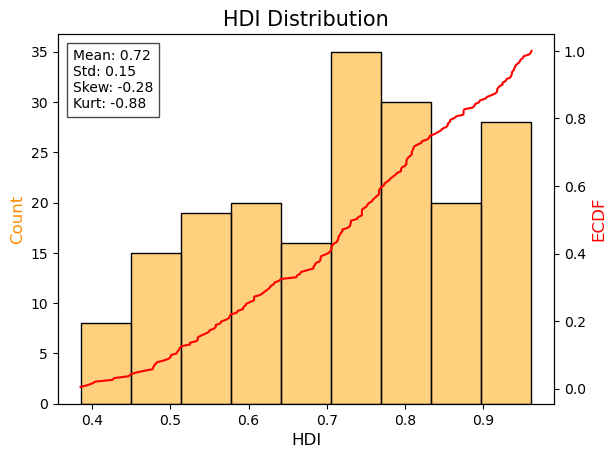

In [155]:
# Plotting histogram
sns.histplot(hdi_df['HDI'], color='orange', alpha=0.5)

# Creating meaningful labels with corresponding colors and readable font sizes
plt.xlabel('HDI', fontsize=12)
plt.ylabel('Count', fontsize=12, color='#FF8C00')

# Create a second y-axis for ECDF
ax2 = plt.gca().twinx()

# Computing ECDF
sorted_hdi = np.sort(hdi_df['HDI'])
n = sorted_hdi.size
ecdf = np.arange(1, n + 1) / n

# Plotting ECDF
ax2.plot(sorted_hdi, ecdf, color='red')
ax2.set_ylabel('ECDF', fontsize=12, color = 'red')

# Adding mean, standard deviation, skewness, and kurtosis to the legend
mean_hdi, standard_dev_hdi, skewness_hdi, kurtosis_hdi = hdi_df['HDI'].mean(), hdi_df['HDI'].std(), skew(hdi_df['HDI']), kurtosis(hdi_df['HDI'])
plt.text(0.03, 0.8, 'Mean: {:.2f}\nStd: {:.2f}\nSkew: {:.2f}\nKurt: {:.2f}'.format(mean_hdi, standard_dev_hdi, skewness_hdi, kurtosis_hdi),
         transform=plt.gca().transAxes, fontsize=10,  bbox=dict(facecolor='white', alpha=0.7))

# Adding title
plt.title('HDI Distribution', fontsize=15)

plt.show()

[0.0, 0.020263157894736844, 0.04052631578947369, 0.06078947368421053, 0.08105263157894738, 0.10131578947368422, 0.12157894736842106, 0.1418421052631579, 0.16210526315789475, 0.1823684210526316, 0.20263157894736844, 0.22289473684210528, 0.24315789473684213, 0.263421052631579, 0.2836842105263158, 0.30394736842105263, 0.3242105263157895, 0.3444736842105264, 0.3647368421052632, 0.385, 0.39654, 0.40808, 0.41962, 0.43116, 0.4427, 0.45424, 0.46578, 0.47732, 0.48886, 0.5004, 0.5119400000000001, 0.52348, 0.53502, 0.54656, 0.5581, 0.56964, 0.58118, 0.59272, 0.60426, 0.6158, 0.62734, 0.63888, 0.65042, 0.66196, 0.6735, 0.68504, 0.69658, 0.7081200000000001, 0.71966, 0.7312000000000001, 0.74274, 0.7542800000000001, 0.76582, 0.77736, 0.7888999999999999, 0.80044, 0.8119799999999999, 0.82352, 0.83506, 0.8466, 0.85814, 0.86968, 0.88122, 0.89276, 0.9043, 0.91584, 0.92738, 0.93892, 0.95046, 0.962, 1]


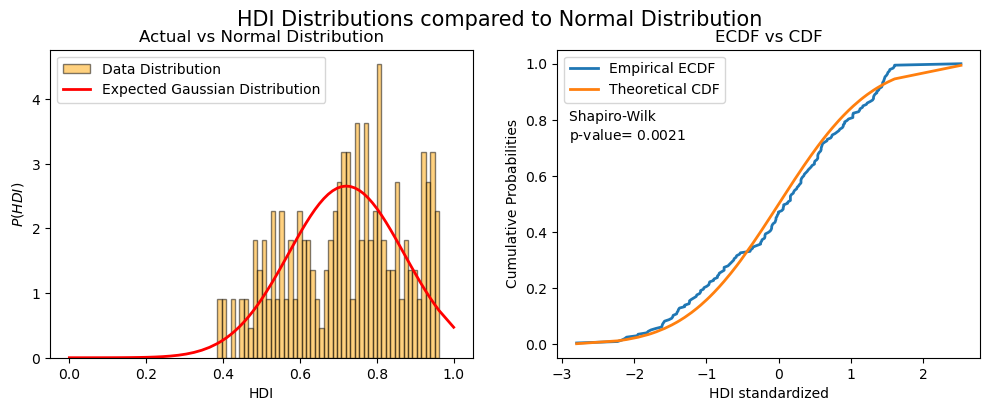

In [156]:
# FIT normal distribution
# RUN Shapiro-Wilk test

data =  hdi_df['HDI'].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting histogram
counts_norm, bins, ignored = ax1.hist(data, 
                                      bins=50,
                                      color='orange', 
                                      alpha=0.5,
                                      density=True,
                                      label="Data Distribution",
                                      edgecolor = "black")

# normal pdf
    # use sigma and mu from the maximal likelyhood guassian distribution not the data
mu = np.mean(data)
sigma = np.std(data)

# add bin to smooth it for whole HDI ranoge 0 to 1
bins = list(bins)
bins = np.linspace(0, bins[0], num=20).tolist() + bins[1:]
bins.append(1) 
print(bins)

ax1.plot(bins, 
         stats.norm.pdf(bins, loc=mu, scale=sigma),
         color='red', 
         label="Expected Gaussian Distribution",
         linewidth=2)

# Adding title
ax1.set_title('Actual vs Normal Distribution', fontsize=12)
ax1.legend(loc="upper left")
ax1.set_ylabel('$P(HDI)$')
ax1.set_xlabel('HDI')


# plot ecdf alongside the theoretical cdf
# Computing and plotting normalized ECDF
data.append(0.3)  #append data so cdf starts approx close to 0
data.append(1.1)  #append data so cdf ends approx close to 1
sorted_hdi = np.sort((data-mu)/sigma)
n = sorted_hdi.size
ecdf = np.arange(1, n + 1) / n
ax2.plot(sorted_hdi, 
        ecdf,
        label="Empirical ECDF",
        linewidth=2)

# Plot theoretical CDF
ax2.plot(sorted_hdi, 
            stats.norm.cdf(sorted_hdi), 
            label ='Theoretical CDF',
            linewidth=2
            )

# run the Shapiro-Wilk test
pval =  stats.shapiro(data)[1]
ax2.text(-2.9, 0.73, 'Shapiro-Wilk \np-value= $%.4f$'%pval)

ax2.set_xlabel('HDI standardized')
ax2.set_ylabel('Cumulative Probabilities')
ax2.set_title('ECDF vs CDF', fontsize=12)

plt.legend(fontsize=10)
fig.suptitle('HDI Distributions compared to Normal Distribution', fontsize=15, ha='center')

plt.show()

The Shapiro-Wilk test tests the null hypothesis that the sample was drawn from a normal distribution. Since p-value is $0.0001$ we can not reject the Null Hypothesis that the HDI distribution is drawn from a normal distribution.

In [157]:
# Creating color palette for the regions
region_col = merged_df["Region"].unique()
color_dict = dict(sorted(dict(zip(region_col, sns.color_palette("muted", len(region_col)))).items()))

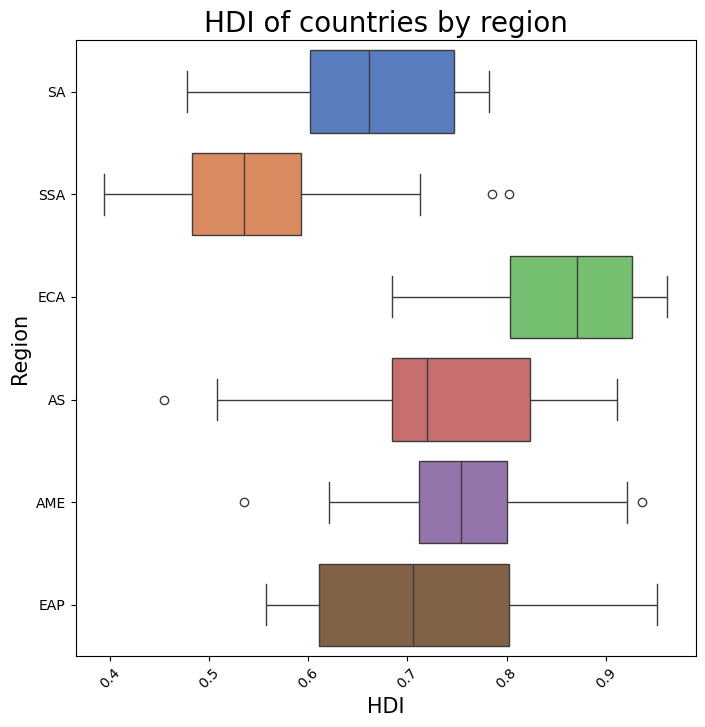

In [158]:
plt.figure(figsize=(8, 8))  # Increase the height of the figure

sns.boxplot(data=merged_df, x='HDI', y='Region', hue='Region', palette=color_dict)

# Increase font of the title and the labels
plt.title('HDI of countries by region', fontsize=20)
plt.xlabel('HDI', fontsize=15)
plt.ylabel('Region', fontsize=15)
plt.xticks(rotation=45)
plt.show()

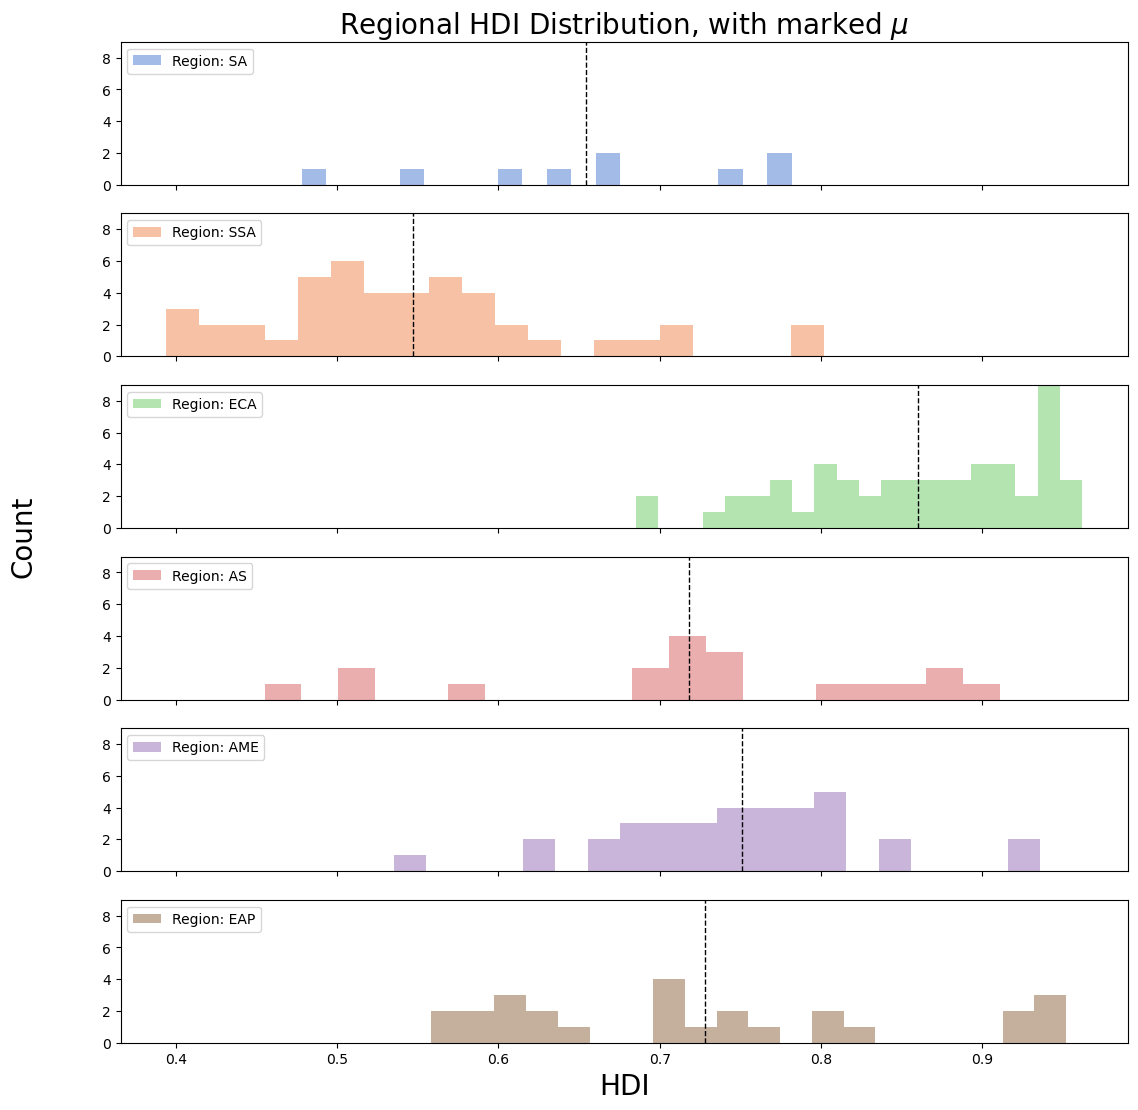

In [202]:
# Creating a figure with 6 subplots, one for each region
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(13, 13), sharex=True)

#Finding the max count across all regions 
max_count = 0
for region in merged_df['Region'].unique():
    subset = merged_df[merged_df['Region'] == region]
    counts, _ = np.histogram(subset['HDI'], bins=20)
    max_count = max(max_count, max(counts))

for i, region in enumerate(merged_df['Region'].unique().tolist()):
    subset = merged_df[merged_df['Region'] == region]
    # Plot the histogram for the HDI of the current region and assigning a label
    axes[i].hist(subset['HDI'], bins=20, alpha=0.5, color=color_dict[region], label=f'Region: {region}')
    # Add a vertical line for the mean HDI
    axes[i].axvline(subset['HDI'].mean(), color='black', linestyle='dashed', linewidth=1)
    # Display the legend for the subplot with the region as the label
    axes[i].legend(loc= 'upper left')
    #Setting y-axis limits to be the same for all subplots
    axes[i].set_ylim(0, max_count)

# Adjusting the y-axis label to be in the middle of the plots
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', size=20)
axes[0].set_title('Regional HDI Distribution, with marked $\mu$',size=20, )
# Adding a general x-axis label for clarity
axes[-1].set_xlabel('HDI', size=20)
plt.show()


In [160]:
#Performing a ANVOA test to see if the mean HDI is significantly different between the regions
HDI_anova = stats.f_oneway(
    merged_df[merged_df['Region'] == 'EAP']['HDI'],
    merged_df[merged_df['Region'] == 'ECA']['HDI'],
    merged_df[merged_df['Region'] == 'AME']['HDI'],
    merged_df[merged_df['Region'] == 'SSA']['HDI'],
    merged_df[merged_df['Region'] == 'SA']['HDI'],
    merged_df[merged_df['Region'] == 'AS']['HDI'],
    )

#Returning the results of the ANOVA test, and printing the conclusion
if HDI_anova[1] < 0.05:
    print("We can conclude that the mean HDI is significantly different between the regions with a p-value of",
           HDI_anova[1],  "\n and reject the null hypothesis that all means are the same") 
else:
    print("We can conclude that the mean HDI is not significantly different between the regions, with a p-value of", HDI_anova[1],
           ' \n And cannot reject the null hypothesis that all means are the same')

We can conclude that the mean HDI is significantly different between the regions with a p-value of 1.0831394665476745e-33 
 and reject the null hypothesis that all means are the same


In [161]:
#Defining HDI standard deviation, error, and size for each region
HDI_std = merged_df.groupby('Region')['HDI'].std()
HDI_mean = merged_df.groupby('Region')['HDI'].mean()
HDI_size = merged_df.groupby('Region')['HDI'].size()

In [163]:
#Comparing every region to every other region in terms of means similarity considering similar variance
compared_reg = []
samevar_dict = {
     'Region Pair' : [],
     'p-value' : [],
     'size_pair' : [],
     'mean_pair' : [],
    'std_pair' : []
}  
#Iterating over all the regions
for region_base in merged_df['Region'].unique():
    #Iterating over all the regions again to create the pairs 
    for region_compare in merged_df['Region'].unique():
        #Checking so the regions are not the same
        if region_base != region_compare:
                #Checking so the regions are not already compared
                if region_compare not in compared_reg:
                    #Performing the student t-test and appending the results to the dictionary
                    t, p = stats.ttest_ind(merged_df[merged_df['Region'] == region_base]['HDI'], merged_df[merged_df['Region'] == region_compare]['HDI'], equal_var=True)
                    p = round(p, 4)
                    #Storing the sample size, mean, and standard deviation, p-value for each region pair
                    samevar_dict['Region Pair'].append(region_base + ' vs ' + region_compare)
                    samevar_dict['p-value'].append(p)
                    samevar_dict['size_pair'].append((HDI_size[region_base], HDI_size[region_compare]))
                    samevar_dict['mean_pair'].append((round(HDI_mean[region_base],3), round(HDI_mean[region_compare],3)))
                    samevar_dict['std_pair'].append((round(HDI_std[region_base],3), round(HDI_std[region_compare],3)))
    compared_reg.append(region_base) #Saving region to avoid comparing it again

t_test_df = pd.DataFrame(samevar_dict)
t_test_df = t_test_df.sort_values(by='p-value', ascending = False)
t_test_df.set_index('Region Pair', inplace=True)
t_test_df.to_csv('data/HDI_t_test_df.csv') 
t_test_df

,p-value,size_pair,mean_pair,std_pair
Region Pair,,,,
AS vs EAP,0.8016,"(19, 26)","(0.718, 0.728)","(0.131, 0.129)"
AME vs EAP,0.3921,"(35, 26)","(0.751, 0.728)","(0.08, 0.129)"
AS vs AME,0.2543,"(19, 35)","(0.718, 0.751)","(0.131, 0.08)"
SA vs AS,0.2090,"(9, 19)","(0.654, 0.718)","(0.104, 0.131)"
SA vs EAP,0.1296,"(9, 26)","(0.654, 0.728)","(0.104, 0.129)"
SA vs AME,0.0038,"(9, 35)","(0.654, 0.751)","(0.104, 0.08)"
SA vs SSA,0.0035,"(9, 45)","(0.654, 0.547)","(0.104, 0.094)"
SA vs ECA,0.0000,"(9, 54)","(0.654, 0.86)","(0.104, 0.074)"
SSA vs ECA,0.0000,"(45, 54)","(0.547, 0.86)","(0.094, 0.074)"


In [164]:
#Comparing every region to every other region in terms of means similarity considering variance not being similar, same code structure as above except for
##Different t-test
compared_reg = []
diffvar_dict = {
     'Region Pair' : [],
     'p-value' : [],
     'size_pair' : [],
     'mean_pair' : [],
    'std_pair' : []
}  
for region_base in merged_df['Region'].unique():
    for region_compare in merged_df['Region'].unique():
        if region_base != region_compare:
                if region_compare not in compared_reg:
                    #Performing the Welsch t-test and appending the results to the dictionary
                    t, p = stats.ttest_ind(merged_df[merged_df['Region'] == region_base]['HDI'], merged_df[merged_df['Region'] == region_compare]['HDI'], equal_var=False)
                    p = round(p, 4)
                    diffvar_dict['Region Pair'].append(region_base + ' vs ' + region_compare)
                    diffvar_dict['p-value'].append(p)
                    diffvar_dict['size_pair'].append((HDI_size[region_base], HDI_size[region_compare]))
                    diffvar_dict['mean_pair'].append((round(HDI_mean[region_base],3), round(HDI_mean[region_compare],3)))
                    diffvar_dict['std_pair'].append((round(HDI_std[region_base],3), round(HDI_std[region_compare],3)))
    compared_reg.append(region_base)

welsch_t_test_df = pd.DataFrame(diffvar_dict)

welsch_t_test_df = welsch_t_test_df.sort_values(by='p-value', ascending = False)
welsch_t_test_df.set_index('Region Pair', inplace=True)
welsch_t_test_df.to_csv('data/HDI_welsch_t_test_df.csv') 
welsch_t_test_df

,p-value,size_pair,mean_pair,std_pair
Region Pair,,,,
AS vs EAP,0.8023,"(19, 26)","(0.718, 0.728)","(0.131, 0.129)"
AME vs EAP,0.4250,"(35, 26)","(0.751, 0.728)","(0.08, 0.129)"
AS vs AME,0.3257,"(19, 35)","(0.718, 0.751)","(0.131, 0.08)"
SA vs AS,0.1764,"(9, 19)","(0.654, 0.718)","(0.104, 0.131)"
SA vs EAP,0.1013,"(9, 26)","(0.654, 0.728)","(0.104, 0.129)"
SA vs AME,0.0245,"(9, 35)","(0.654, 0.751)","(0.104, 0.08)"
SA vs SSA,0.0154,"(9, 45)","(0.654, 0.547)","(0.104, 0.094)"
SA vs ECA,0.0002,"(9, 54)","(0.654, 0.86)","(0.104, 0.074)"
ECA vs AS,0.0002,"(54, 19)","(0.86, 0.718)","(0.074, 0.131)"


As we can see we have a couple of ouliers (if we determine them by IQR). Lets look at them separately:

In [165]:
merged_df[merged_df['Region'] == 'SSA'].sort_values(by='HDI', ascending=False).head(4)

,HDI Group,HDI,Region,IQ
Country,,,,
Mauritius,Very High,0.802,SSA,88.0
Seychelles,High,0.785,SSA,84.4
South Africa,High,0.713,SSA,71.6
Gabon,High,0.706,SSA,69.0


The HDI of the Seychelles and the HDI of Mauritius is 10-15% higher than the HDI of the next best country.

In [166]:
merged_df[merged_df['Region'] == 'AS'].sort_values(by='HDI', ascending=False).tail(4)

,HDI Group,HDI,Region,IQ
Country,,,,
Syria,Medium,0.577,AS,82.0
Djibouti,Low,0.509,AS,75.0
Sudan,Low,0.508,AS,77.5
Yemen,Low,0.455,AS,80.5


The HDI of Yemen is about 10% lower than the HDI of the next lowest country.

In [167]:
merged_df[merged_df['Region'] == 'AME'].sort_values(by='HDI', ascending=False).tail(4)

,HDI Group,HDI,Region,IQ
Country,,,,
Nicaragua,Medium,0.667,AME,84.0
Guatemala,Medium,0.627,AME,79.0
Honduras,Medium,0.621,AME,81.0
Haiti,Low,0.535,AME,67.0


The HDI of Haiti is about 15% lower than the HDI of the next lowest country.

In [168]:
merged_df[merged_df['Region'] == 'AME'].sort_values(by='HDI', ascending=False).head(4)

,HDI Group,HDI,Region,IQ
Country,,,,
Canada,Very High,0.936,AME,100.4
United States,Very High,0.921,AME,97.5
Chile,Very High,0.855,AME,89.8
Argentina,Very High,0.842,AME,92.8


We can see that Canada is classified as an outlier (as expected) and is by almost 10% higher than Chile. The US is still not classified as an outlier even though it might look like as an outlier (and we would expect it to be one).

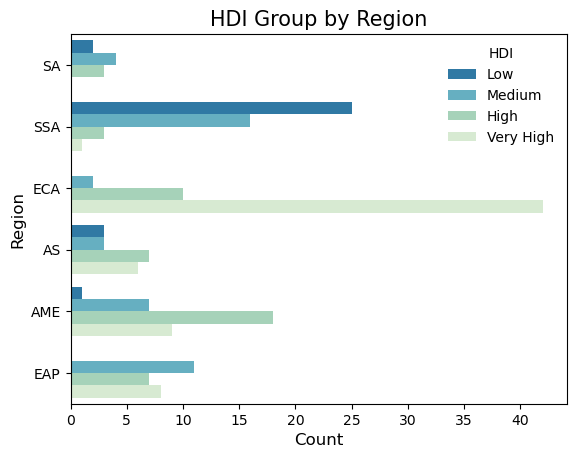

In [169]:
# Creating a count plot for the HDI Groups
sns.countplot(data=merged_df, 
              y="Region", 
              hue="HDI Group", 
              #order=merged_df["Region"], # bug creates sub hue plots
              palette="GnBu_r")

plt.legend(title="HDI",frameon=False)
plt.title('HDI Group by Region', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Region', fontsize=12)

# Add error bars

plt.show()

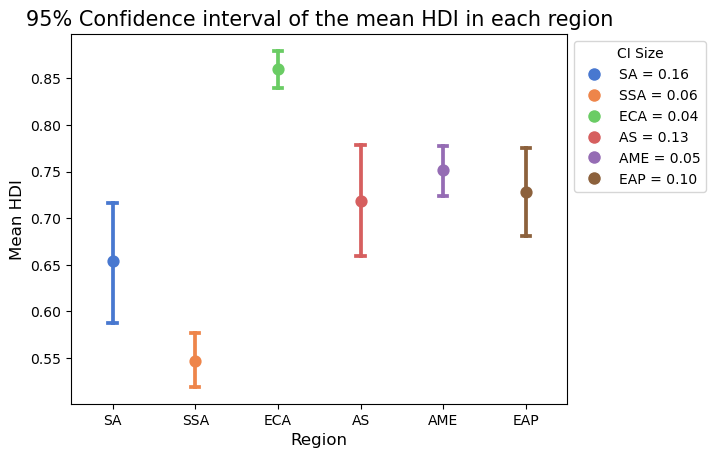

In [170]:
# the interval of the average HDI for each region with a 95% confidence interval (pointplot)
sns.pointplot(x='Region', y='HDI', hue='Region', data=merged_df, estimator=np.mean, errorbar=('ci', 95), palette=color_dict, capsize=0.1)
plt.title('95% Confidence interval of the mean HDI in each region', fontsize=15)
ci_data = []
for region in merged_df['Region'].unique():
    mean = np.mean(merged_df[merged_df['Region']==region]['HDI'])
    stderr = stats.sem(merged_df[merged_df['Region']==region]['HDI'])
    ci = stats.t.interval(0.95, len(merged_df[merged_df['Region']==region]['HDI'])-1, loc=mean, scale=stderr)
    ci_size = ci[1] - ci[0]
    ci_data.append((region, ci_size))
legend_labels = [f'{region} = {ci_size:.2f}' for region, ci_size in ci_data]
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_dict[region]) for region, _ in ci_data]
plt.legend(handles=handles, labels=legend_labels, title='CI Size', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Region', fontsize=12)
plt.ylabel('Mean HDI', fontsize=12)
plt.show()


### 3.1.2 IQ

The IQ of the world is distributed normally around 100. As this looks at the IQ of the population of the world and in our analysis we have the IQ of different countries to get the same result we would have to give our countries different weights to achieve the same result (as this datasets gives the same weigth for India and Hungary even though their population differs massively). Thus, this distriubtuion is not normal around 100 (or slightly underneath), as this is a histogram of countries and not population individuals. But it shows that more countries have under average (=100) IQ.

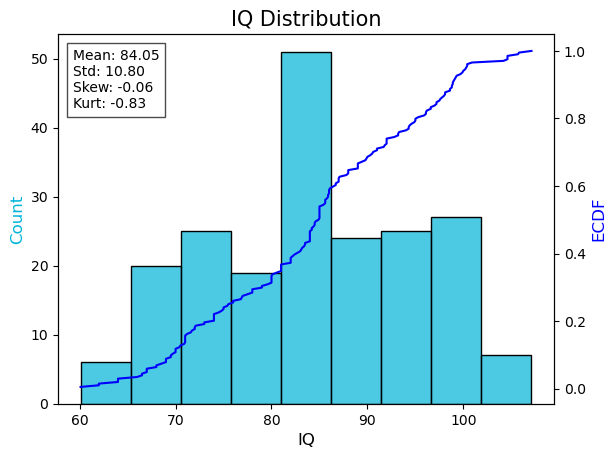

In [171]:
# Plot histogram
sns.histplot(iq_df['IQ'], color='#00b4d8', alpha=0.7)
# Setting readable labels with corresponding colors and font sizes
plt.xlabel('IQ', fontsize=12)
plt.ylabel('Count', fontsize=12, color='#00b4d8')

# Create a second y-axis for ECDF
ax2 = plt.gca().twinx()

# Computeing ECDF
sorted_hdi = np.sort(iq_df['IQ'])
n = sorted_hdi.size
ecdf = np.arange(1, n + 1) / n

# Plotting ECDF
ax2.plot(sorted_hdi, ecdf, color='blue')
ax2.set_ylabel('ECDF', fontsize=12, color = 'blue')

# Calculating and adding mean, standard deviation, skewness, and kurtosis to the legend
mean_iq, standard_dev_iq, skewness_iq, kurtosis_iq = merged_df['IQ'].mean(), merged_df['IQ'].std(), skew(merged_df['IQ']), kurtosis(merged_df['IQ'])
plt.text(0.03, 0.8, 'Mean: {:.2f}\nStd: {:.2f}\nSkew: {:.2f}\nKurt: {:.2f}'.format(mean_iq, standard_dev_iq, skewness_iq, kurtosis_iq),
         transform=plt.gca().transAxes, fontsize=10,  bbox=dict(facecolor='white', alpha=0.7))

# Add title
plt.title('IQ Distribution', fontsize=15)

plt.show()

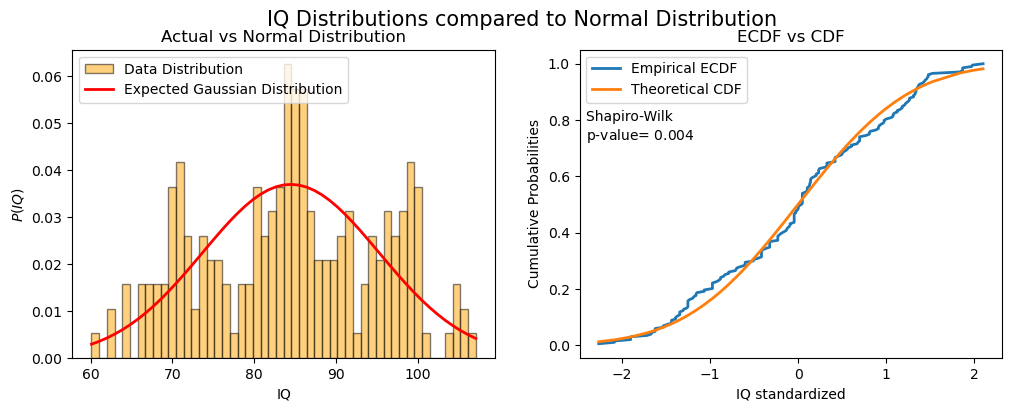

In [172]:
# FIT normal distribution
# RUN Shapiro-Wilk test

data =  iq_df['IQ'].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting histogram
counts_norm, bins, ignored = ax1.hist(data, 
                                      bins=50,
                                      color='orange', 
                                      alpha=0.5,
                                      density=True,
                                      label="Data Distribution",
                                      edgecolor = "black")

# normal pdf
    # use sigma and mu from the maximal likelyhood guassian distribution not the data
mu = np.mean(data)
sigma = np.std(data)

# add bin to smooth it for whole HDI ranoge 0 to 1
bins = list(bins)

ax1.plot(bins, 
         stats.norm.pdf(bins, loc=mu, scale=sigma),
         color='red', 
         label="Expected Gaussian Distribution",
         linewidth=2)

# Adding title
ax1.set_title('Actual vs Normal Distribution', fontsize=12)
ax1.legend(loc="upper left")
ax1.set_ylabel('$P(IQ)$')
ax1.set_xlabel('IQ')


# plot ecdf alongside the theoretical cdf
# Computing and plotting normalized ECDF
sorted_hdi = np.sort((data-mu)/sigma)
n = sorted_hdi.size
ecdf = np.arange(1, n + 1) / n
ax2.plot(sorted_hdi, 
        ecdf,
        label="Empirical ECDF",
        linewidth=2)

# Plot theoretical CDF
ax2.plot(sorted_hdi, 
            stats.norm.cdf(sorted_hdi), 
            label ='Theoretical CDF',
            linewidth=2
            )

# run the Shapiro-Wilk test
pval =  stats.shapiro(data)[1]
ax2.text(-2.4, 0.73, 'Shapiro-Wilk \np-value= $%.3f$'%pval)

ax2.set_xlabel('IQ standardized')
ax2.set_ylabel('Cumulative Probabilities')
ax2.set_title('ECDF vs CDF', fontsize=12)

plt.legend(fontsize=10)
fig.suptitle('IQ Distributions compared to Normal Distribution', fontsize=15, ha='center')

plt.show()

For the IQ the Shaprio-Wilk test returns a p-value of 0.004, so as before we cannot reject the Null Hypothesis that the IQ distribution was drawn from a normal distribution.

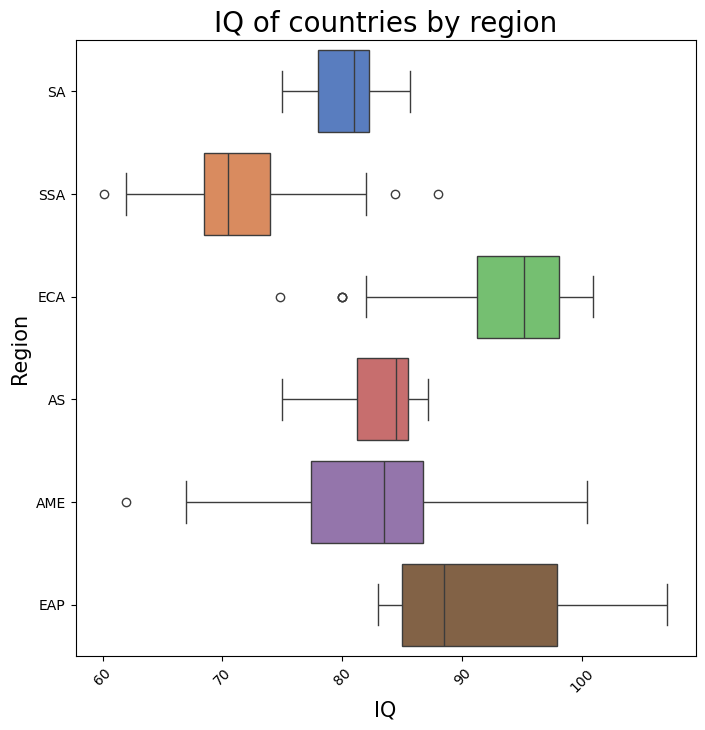

In [173]:
# Create a boxplot for the HDI of the countries sorted by region
plt.figure(figsize=(8,8))
sns.boxplot(data=merged_df, x='IQ', y='Region', hue = 'Region', palette=color_dict)
# Increase font of the title and the labels
plt.title('IQ of countries by region', fontsize=20)
plt.xlabel('IQ', fontsize=15)
plt.ylabel('Region', fontsize=15)
plt.xticks(rotation=45)

plt.show()

In [174]:
#Saving the standard deviation, mean, and size of the IQ for each region
IQ_std = merged_df.groupby('Region')['IQ'].std()
IQ_mean = merged_df.groupby('Region')['IQ'].mean()
IQ_size = merged_df.groupby('Region')['IQ'].size()

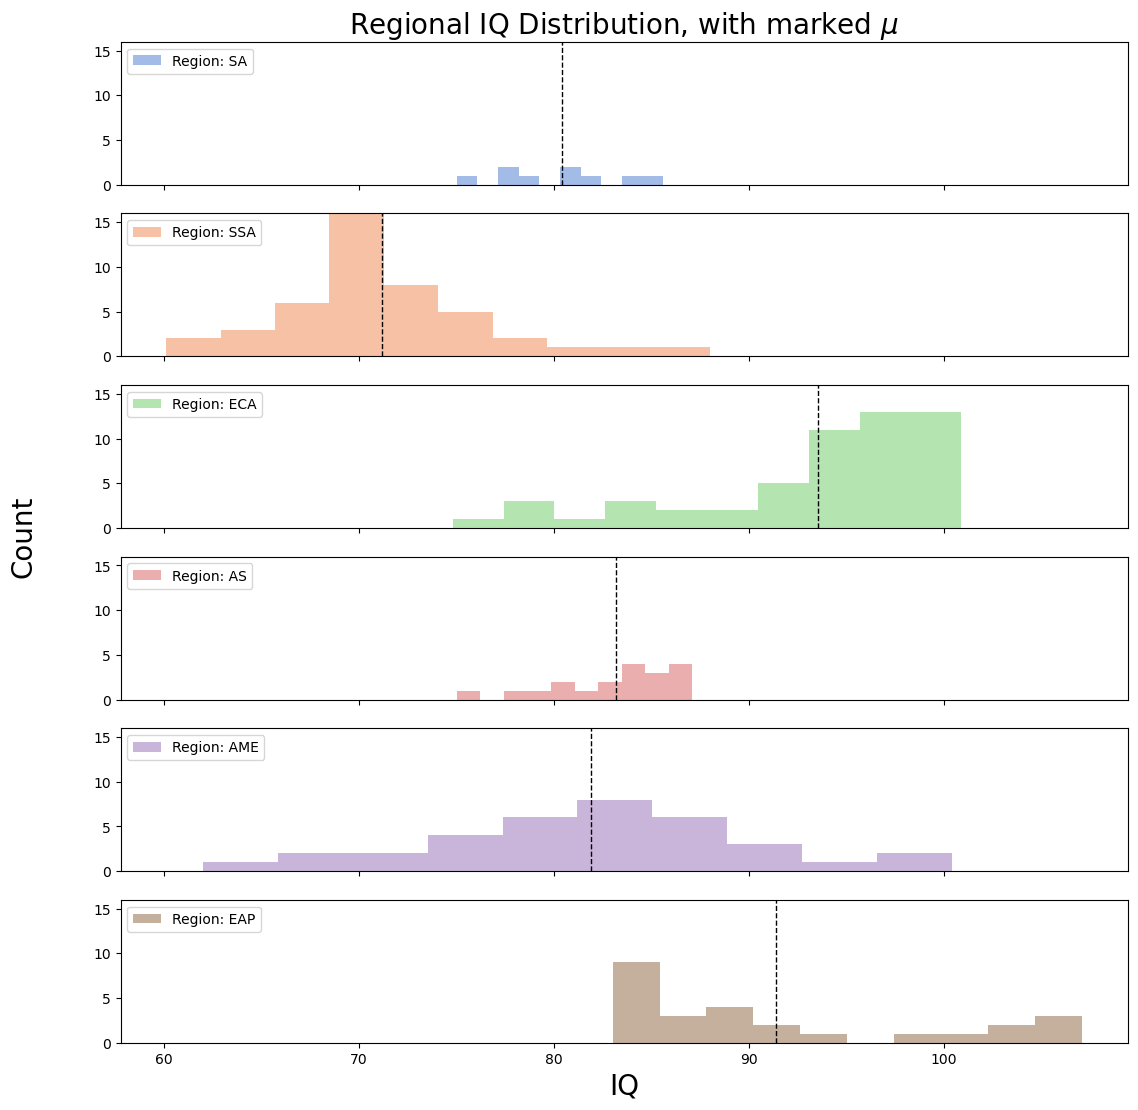

In [203]:

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(13, 13), sharex=True)


max_count = 0
for region in merged_df['Region'].unique():
    subset = merged_df[merged_df['Region'] == region]
    counts, _ = np.histogram(subset['IQ'], bins=10)
    max_count = max(max_count, max(counts))

for i, region in enumerate(merged_df['Region'].unique().tolist()):
    subset = merged_df[merged_df['Region'] == region]
    # Plot the histogram for the HDI of the current region and assigning it a label
    axes[i].hist(subset['IQ'], bins=10, alpha=0.5, color=color_dict[region], label=f'Region: {region}')
    # Add a vertical line for the mean HDI
    axes[i].axvline(subset['IQ'].mean(), color='black', linestyle='dashed', linewidth=1)
    # Display the legend for the subplot with the region as the label
    axes[i].legend(loc= 'upper left')
    #Set y_axis limit to be the same for all subplots 
    axes[i].set_ylim(0, max_count)

# Adjusting the y-axis label to be in the middle of the plots
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', size=20)
axes[0].set_title('Regional IQ Distribution, with marked $\mu$',size=20, )
# Adding a general x-axis label for clarity
axes[-1].set_xlabel('IQ', size=20)
plt.show()

In [177]:
#Performing an ANOVA test to see if the IQ is significantly different between the regions
IQ_anova = stats.f_oneway(
    merged_df[merged_df['Region'] == 'EAP']['IQ'],
    merged_df[merged_df['Region'] == 'ECA']['IQ'],
    merged_df[merged_df['Region'] == 'AME']['IQ'],
    merged_df[merged_df['Region'] == 'SSA']['IQ'],
    merged_df[merged_df['Region'] == 'SA']['IQ'],
    merged_df[merged_df['Region'] == 'AS']['IQ'],
    )

if IQ_anova[1] < 0.05:
    print("We can conclude that the mean IQ is significantly different between the regions with a p-value of",
           IQ_anova[1],  "\n and reject the null hypothesis that all means are the same") 
else:
    print("We can conclude that the mean IQ is not significantly different between the regions, with a p-value of", IQ_anova[1],
           ' \n And cannot reject the null hypothesis that all means are the same')

We can conclude that the mean IQ is significantly different between the regions with a p-value of 4.815581026953404e-39 
 and reject the null hypothesis that all means are the same


In [178]:
#Comparing every region to every other region in terms of means similarity considering similar variance, same code structure as the comparison made on the HDI pairs
##with changed variables to IQ 
compared_reg = []
samevar_dict = {
     'Region Pair' : [],
     'p-value' : [],
     'size_pair' : [],
     'mean_pair' : [],
    'std_pair' : []
}  
for region_base in merged_df['Region'].unique():
    for region_compare in merged_df['Region'].unique():
        if region_base != region_compare:
                if region_compare not in compared_reg:
                    t, p = stats.ttest_ind(merged_df[merged_df['Region'] == region_base]['IQ'], merged_df[merged_df['Region'] == region_compare]['IQ'], equal_var=True)
                    p = round(p, 4)
                    samevar_dict['Region Pair'].append(region_base + ' vs ' + region_compare)
                    samevar_dict['p-value'].append(p)
                    samevar_dict['size_pair'].append((IQ_size[region_base], IQ_size[region_compare]))
                    samevar_dict['mean_pair'].append((round(IQ_mean[region_base],3), round(IQ_mean[region_compare],3)))
                    samevar_dict['std_pair'].append((round(IQ_std[region_base],3), round(IQ_std[region_compare],3)))
    compared_reg.append(region_base)

t_test_df = pd.DataFrame(samevar_dict)
t_test_df = t_test_df.sort_values(by='p-value', ascending = False)
t_test_df.set_index('Region Pair', inplace=True)
t_test_df.to_csv('data/IQt_test_df.csv') 
t_test_df


    

,p-value,size_pair,mean_pair,std_pair
Region Pair,,,,
SA vs AME,0.6098,"(9, 35)","(80.422, 81.9)","(3.29, 8.397)"
AS vs AME,0.5300,"(19, 35)","(83.174, 81.9)","(3.344, 8.397)"
ECA vs EAP,0.2006,"(54, 26)","(93.556, 91.404)","(6.279, 8.283)"
SA vs AS,0.0513,"(9, 19)","(80.422, 83.174)","(3.29, 3.344)"
SA vs EAP,0.0005,"(9, 26)","(80.422, 91.404)","(3.29, 8.283)"
AS vs EAP,0.0002,"(19, 26)","(83.174, 91.404)","(3.344, 8.283)"
SA vs SSA,0.0000,"(9, 45)","(80.422, 71.167)","(3.29, 5.361)"
SA vs ECA,0.0000,"(9, 54)","(80.422, 93.556)","(3.29, 6.279)"
SSA vs ECA,0.0000,"(45, 54)","(71.167, 93.556)","(5.361, 6.279)"


In [179]:
#Comparing every region to every other region in terms of means similarity considering dissimilar variance, same code structure as above
##with Welsch t-test
compared_reg = []
diffvar_dict = {
     'Region Pair' : [],
     'p-value' : [],
     'size_pair' : [],
     'mean_pair' : [],
    'std_pair' : []
}  
for region_base in merged_df['Region'].unique():
    for region_compare in merged_df['Region'].unique():
        if region_base != region_compare:
                if region_compare not in compared_reg:
                    t, p = stats.ttest_ind(merged_df[merged_df['Region'] == region_base]['IQ'], merged_df[merged_df['Region'] == region_compare]['IQ'], equal_var=False)
                    p = round(p, 4)
                    diffvar_dict['Region Pair'].append(region_base + ' vs ' + region_compare)
                    diffvar_dict['p-value'].append(p)
                    diffvar_dict['size_pair'].append((IQ_size[region_base], IQ_size[region_compare]))
                    diffvar_dict['mean_pair'].append((round(IQ_mean[region_base],3), round(IQ_mean[region_compare],3)))
                    diffvar_dict['std_pair'].append((round(IQ_std[region_base],3), round(IQ_std[region_compare],3)))
    compared_reg.append(region_base)

welsch_t_test_df = pd.DataFrame(diffvar_dict)
welsch_t_test_df=welsch_t_test_df.sort_values(by='p-value', ascending = False)
welsch_t_test_df.set_index('Region Pair', inplace=True)
welsch_t_test_df.to_csv('data/IQ_welsch_t_test_df.csv') 
welsch_t_test_df

,p-value,size_pair,mean_pair,std_pair
Region Pair,,,,
AS vs AME,0.4337,"(19, 35)","(83.174, 81.9)","(3.344, 8.397)"
SA vs AME,0.4157,"(9, 35)","(80.422, 81.9)","(3.29, 8.397)"
ECA vs EAP,0.2481,"(54, 26)","(93.556, 91.404)","(6.279, 8.283)"
SA vs AS,0.0565,"(9, 19)","(80.422, 83.174)","(3.29, 3.344)"
AS vs EAP,0.0001,"(19, 26)","(83.174, 91.404)","(3.344, 8.283)"
SA vs SSA,0.0000,"(9, 45)","(80.422, 71.167)","(3.29, 5.361)"
SA vs ECA,0.0000,"(9, 54)","(80.422, 93.556)","(3.29, 6.279)"
SA vs EAP,0.0000,"(9, 26)","(80.422, 91.404)","(3.29, 8.283)"
SSA vs ECA,0.0000,"(45, 54)","(71.167, 93.556)","(5.361, 6.279)"


In [180]:
merged_df[merged_df['Region'] == 'SSA'].sort_values(by='IQ', ascending=False).head(5)

,HDI Group,HDI,Region,IQ
Country,,,,
Mauritius,Very High,0.802,SSA,88.0
Seychelles,High,0.785,SSA,84.4
Madagascar,Low,0.501,SSA,82.0
Comoros,Medium,0.558,SSA,77.0
Botswana,Medium,0.693,SSA,76.9


Interestingly, Seychelles and Mauritius were both classified as upper outliers (and the only upper outliers) regarding both IQ and HDI.

In [181]:
merged_df[merged_df['Region'] == 'SSA'].sort_values(by='IQ', ascending=False).tail(5)

,HDI Group,HDI,Region,IQ
Country,,,,
Sierra Leone,Low,0.477,SSA,64.0
Cameroon,Medium,0.576,SSA,64.0
Central African Republic,Low,0.404,SSA,64.0
Gambia,Low,0.500,SSA,62.0
Malawi,Low,0.512,SSA,60.1


We can see that Malawi is an outlier but it is not that significantly lower than Gambia

In [182]:
merged_df[merged_df['Region'] == 'ECA'].sort_values(by='IQ', ascending=False).tail(5)

,HDI Group,HDI,Region,IQ
Country,,,,
Albania,High,0.796,ECA,82.0
Turkmenistan,High,0.745,ECA,80.0
Tajikistan,Medium,0.685,ECA,80.0
Uzbekistan,High,0.727,ECA,80.0
Kyrgyzstan,Medium,0.692,ECA,74.8


Here we have Turkmenistan, Tajikistan, Uzbekistan and Kyrgyzistan as outliers. Kyrgyzistan is more obviously an outlier than the other two.

In [183]:
merged_df[merged_df['Region'] == 'AME'].sort_values(by='IQ', ascending=False).tail(5)

,HDI Group,HDI,Region,IQ
Country,,,,
Jamaica,High,0.709,AME,71.0
St Vincent,High,0.751,AME,71.0
Haiti,Low,0.535,AME,67.0
Dominica,High,0.720,AME,67.0
Saint Lucia,High,0.715,AME,62.0


Saint Lucia is classified as a lower outlier.

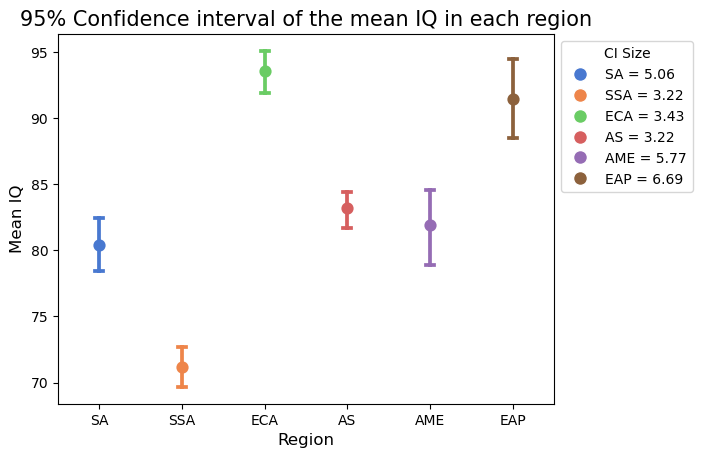

In [184]:
# the interval of the average IQ for each region with a 95% confidence interval (pointplot)
sns.pointplot(x='Region', y='IQ', hue='Region', data=merged_df, estimator=np.mean, errorbar=('ci', 95), palette=color_dict, capsize=0.1)
plt.title('95% Confidence interval of the mean IQ in each region', fontsize=15)
ci_data2 = []
for region in merged_df['Region'].unique():
    mean = np.mean(merged_df[merged_df['Region']==region]['IQ'])
    stderr = stats.sem(merged_df[merged_df['Region']==region]['IQ'])
    ci = stats.t.interval(0.95, len(merged_df[merged_df['Region']==region]['IQ'])-1, loc=mean, scale=stderr)
    ci_size = ci[1] - ci[0]
    ci_data2.append((region, ci_size))
legend_labels = [f'{region} = {ci_size:.2f}' for region, ci_size in ci_data2]
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_dict[region]) for region, _ in ci_data2]
plt.legend(handles=handles, labels=legend_labels, title='CI Size', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Region', fontsize=12)
plt.ylabel('Mean IQ', fontsize=12)
plt.show()

## 3.2  Bivariate analysis

In [185]:
centroids = merged_df[['Region', 'HDI', 'IQ']].groupby('Region').mean()
centroids.apply(lambda x: x)

,HDI,IQ
Region,,
AME,0.751229,81.900000
AS,0.718263,83.173684
EAP,0.728154,91.403846
ECA,0.860019,93.555556
SA,0.654111,80.422222
SSA,0.547022,71.166667


In [186]:
sem_df = merged_df[['Region', 'HDI', 'IQ']].groupby('Region').sem()
sem_df

,HDI,IQ
Region,,
AME,0.013465,1.419315
AS,0.030009,0.767156
EAP,0.025257,1.624358
ECA,0.010100,0.854419
SA,0.034530,1.096684
SSA,0.014047,0.799128


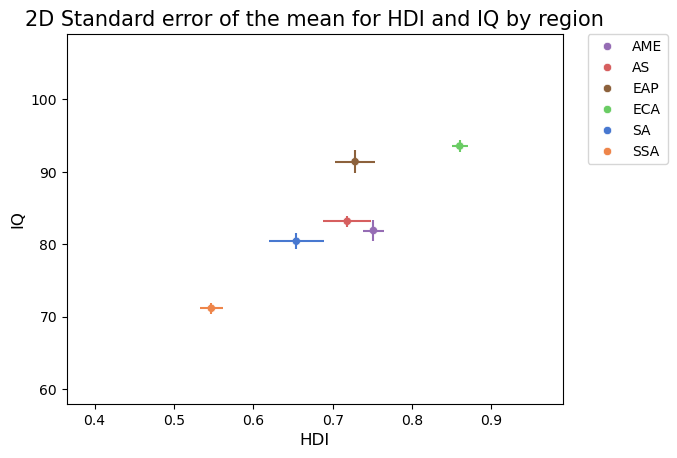

In [187]:
sns.scatterplot(data=centroids, x='HDI', y='IQ', hue='Region', palette=color_dict)
plt.errorbar(centroids['HDI'], centroids['IQ'], xerr=sem_df['HDI'], yerr=sem_df['IQ'], ecolor=color_dict.values(), linestyle='')
plt.ylim(58, 109)
plt.xlim(0.365, 0.99)

plt.title('2D Standard error of the mean for HDI and IQ by region', fontsize=15)
plt.xlabel('HDI', fontsize=12)
plt.ylabel('IQ', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

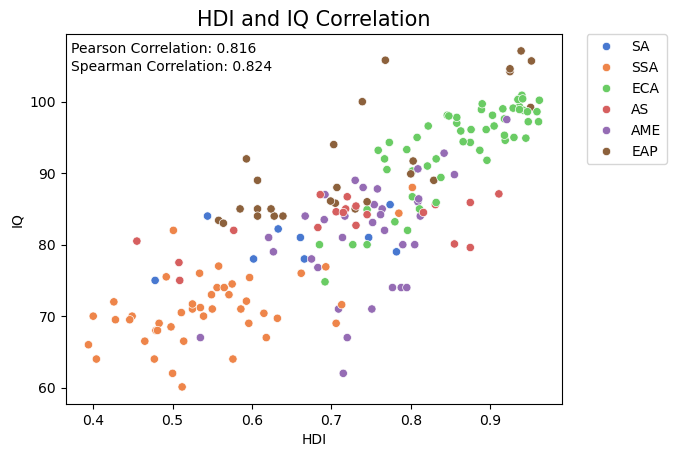

In [188]:
# Create a scatter plot of HDI and IQ correlation, adding a pearson correlation coefficient and a spearman correlation
sns.scatterplot(data=merged_df, x='HDI', y='IQ', hue='Region', palette=color_dict)
pearson_corr = merged_df['HDI'].corr(merged_df['IQ'], method='pearson')
spearman_corr = merged_df['HDI'].corr(merged_df['IQ'], method='spearman')
plt.text(0.01, 0.95, f"Pearson Correlation: {pearson_corr:.3f}", transform=plt.gca().transAxes, fontsize=10, alpha=1)
plt.text(0.01, 0.90, f"Spearman Correlation: {spearman_corr:.3f}", transform=plt.gca().transAxes, fontsize=10, alpha = 1)
plt.title('HDI and IQ Correlation', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [189]:
# calculate linear regression
x = merged_df['HDI']
y = merged_df['IQ']

x = sm.add_constant(x)
model_sm = sm.OLS(y,x).fit()
R2 = model_sm.rsquared
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     IQ   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     370.3
Date:                Sun, 31 Mar 2024   Prob (F-statistic):           4.05e-46
Time:                        13:19:46   Log-Likelihood:                -610.60
No. Observations:                 188   AIC:                             1225.
Df Residuals:                     186   BIC:                             1232.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.5133      2.257     18.391      0.000      37.060      45.966
HDI           58.8819      3.060     19.242      0.000      52.845      64.919
==============================================================================
Omnibus:                        8.845   Durbin-Watson:                   2.281
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               10.511
Skew:                          -0.361   Prob(JB):                      0.00522
Kurtosis:                       3.907   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

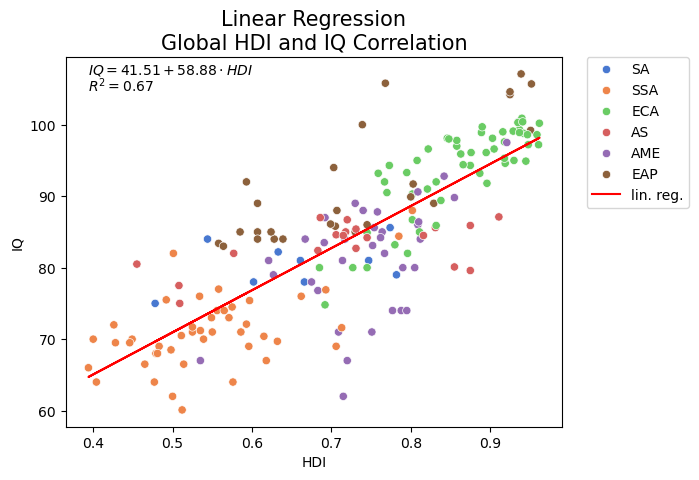

In [190]:
sns.scatterplot(data=merged_df, x='HDI', y='IQ', hue='Region', palette=color_dict)

x=merged_df['HDI']
plt.plot(x, model_sm.fittedvalues, color='red', label="lin. reg.")

a = model_sm.params['const']
b = model_sm.params['HDI']

plt.text(min(x), max(y), '$IQ = %.2f + %.2f \cdot HDI$'%(a,b))
plt.text(min(x), max(y)-2.5, '$R^2 = %.2f$'%R2)

plt.xlabel('HDI')
plt.ylabel('IQ')
plt.title('Linear Regression\nGlobal HDI and IQ Correlation', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

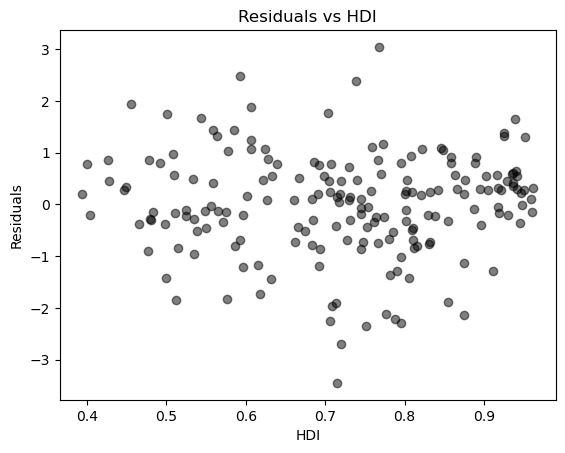

94.15% of the standardized residuals are within 2 standard deviations.


In [191]:
# plot the residuals
st_residuals = model_sm.resid_pearson

#sns.scatterplot(data=merged_df, x='HDI', y=st_residuals, hue='Region', palette=color_dict)

plt.scatter(x, st_residuals, alpha=0.5, color='black')
plt.title('Residuals vs HDI')
plt.xlabel('HDI')
plt.ylabel('Residuals')
plt.show()

perc_within_2std = 100* sum([1 for i in st_residuals if -2 <= i <=2])/len(st_residuals)
print('%.2f%% of the standardized residuals are within 2 standard deviations.' % perc_within_2std)

Looking at the plot of all data points the residuals do not show signs of biases and estimation mistakes. In this case it is enough to not consider regions separately as the model we fitted tries to predict the overall relationship between HDI and IQ. Nevertheless, this does not mean that differences in the estimation errors of the different regions cannot arise.

In [192]:
# Use if you want to see the residuals of only the AME and EAP regions (systematic under-/overestimation)

#color_dict_new = color_dict.copy()
#color_dict_new['ECA'] = (1, 1, 1, 0.01)
#color_dict_new['SSA'] = (1, 1, 1, 0.01)
#color_dict_new['SA'] = (1, 1, 1, 0.01)
#color_dict_new['AS'] = (1, 1, 1, 0.01)

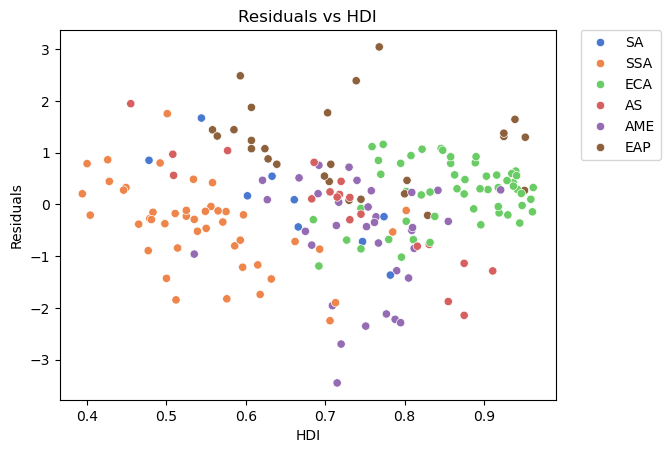

In [193]:
sns.scatterplot(data=merged_df, x='HDI', y=st_residuals, hue='Region', palette=color_dict) # change it up to color_dict_new to blur out the other regions
plt.title('Residuals vs HDI')
plt.xlabel('HDI')
plt.ylabel('Residuals')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

If we look at the plot with the different regions we notice that the Americas region tends to be overestimated while the East Asia and Pacific region tends to be underestimated. The potential bias can arise due to the class unbalances.

/var/folders/gx/rjvt3w81017_cp1lyj8sxr480000gn/T/ipykernel_63338/672522908.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='Region', palette=color_dict)


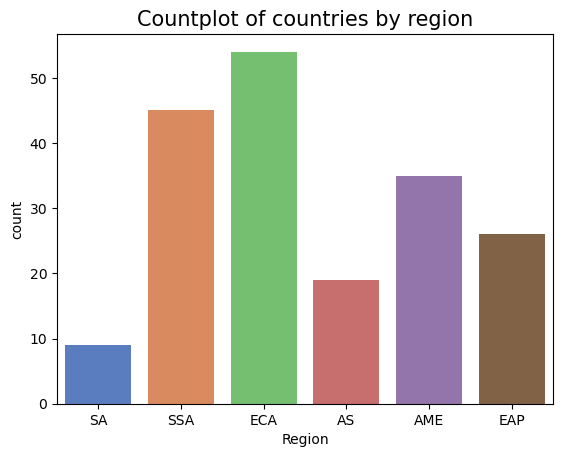

In [194]:
sns.countplot(data=merged_df, x='Region', palette=color_dict)
plt.title('Countplot of countries by region', fontsize=15)

plt.show()

We can see that by the ECA and SSA regions tend to have the most data points, additionally they are also more tightly clustered as the standard error of the mean is way smaller than by other regions, e.g. the spread of the points is smaller than by other regions. When we combine these two factors we understand why the overall model is fitted more to these regions and the regions with lesser data points and higher SEM can be systematically estimated wrongly.

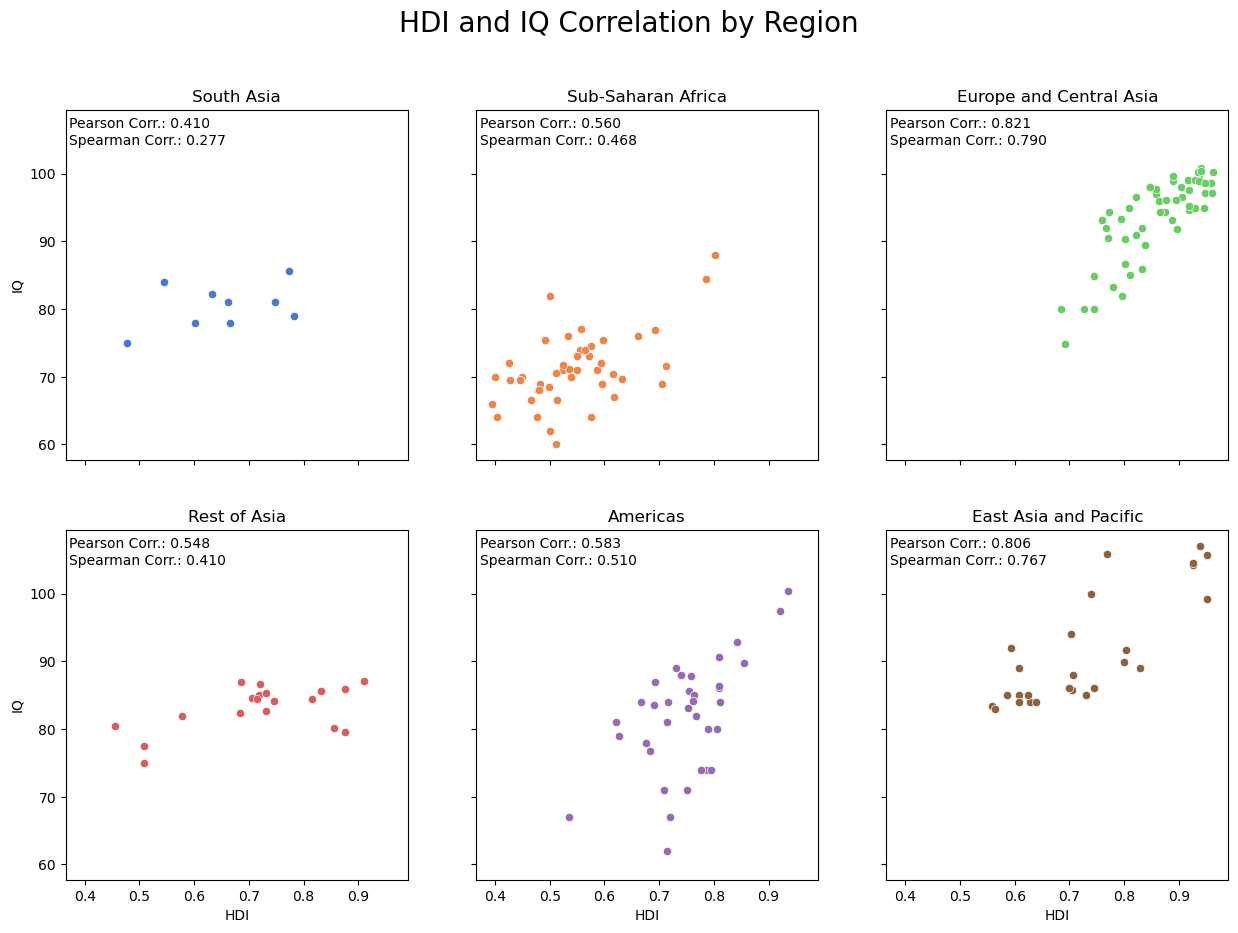

In [195]:
# Creating a scatter plot for each region 
regions_full_name = {
    'SA': 'South Asia',
    'SSA': 'Sub-Saharan Africa',
    'ECA': 'Europe and Central Asia',
    'AS': 'Rest of Asia', 
    'AME': 'Americas', 
    'EAP': 'East Asia and Pacific'
}

regions = ['SA', 'SSA', 'ECA', 'AS', 'AME', 'EAP']

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharex=True, sharey=True)

for region in regions:
    ax = axes[regions.index(region) // 3, regions.index(region) % 3]
    sns.scatterplot(data=merged_df[merged_df['Region'] == region], x='HDI', y='IQ', ax=ax, color=color_dict[region])
    pearson_corr = merged_df[merged_df['Region'] == region]['HDI'].corr(merged_df[merged_df['Region'] == region]['IQ'], method='pearson')
    spearman_corr = merged_df[merged_df['Region'] == region]['HDI'].corr(merged_df[merged_df['Region'] == region]['IQ'], method='spearman')
    ax.text(0.01, 0.95, f"Pearson Corr.: {pearson_corr:.3f}", transform=ax.transAxes, fontsize=10, alpha=1)
    ax.text(0.01, 0.90, f"Spearman Corr.: {spearman_corr:.3f}", transform=ax.transAxes, fontsize=10, alpha=1)
    ax.set_title(f'{regions_full_name[region]}')


plt.suptitle('HDI and IQ Correlation by Region', fontsize=20)
plt.show()

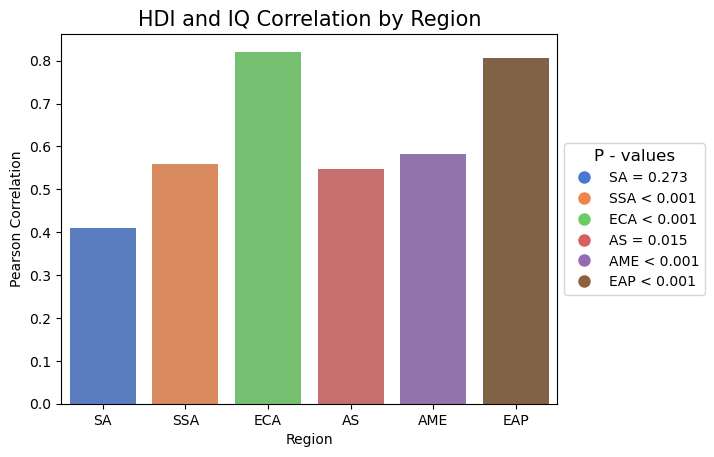

In [196]:
# Checks linear relationship differences per region and the significance of the relationship
pearson_corr_list = []
region_list = []
p_values = []
for region in merged_df['Region'].unique():
    region_data = merged_df[merged_df['Region'] == region]
    pearson_corr_region, p_val = stats.pearsonr(merged_df[merged_df['Region']==region]['HDI'], merged_df[merged_df['Region']==region]['IQ'])
    pearson_corr_list.append(pearson_corr_region)
    region_list.append(region)
    p_values.append(p_val)

region_corr_df = pd.DataFrame({'Region': region_list, 'Pearson Correlation': pearson_corr_list})

sns.barplot(data=region_corr_df, x='Region', y='Pearson Correlation',hue = 'Region', palette=color_dict)
legend_labels = []
for region, p_val in zip(region_corr_df['Region'], p_values):
    if p_val < 0.001:
        legend_labels.append(f'{region} < 0.001')
    else:
        legend_labels.append(f'{region} = {p_val:.3f}')
extra_legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_dict[region]) 
                        for region in region_corr_df['Region']]
legend= plt.legend(extra_legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='P - values') 
legend.get_title().set_fontsize('large')
#plt.text(1.2, 1.05, ' ', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
plt.title('HDI and IQ Correlation by Region', fontsize=15)
plt.show()

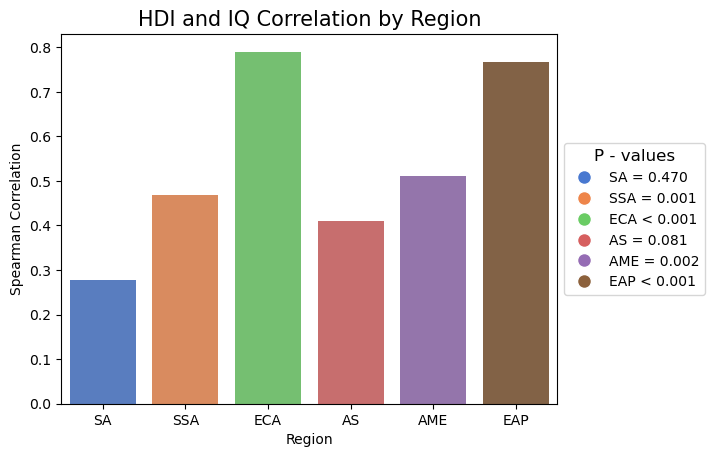

In [197]:
# Check non-linear monotonic relationship differences per region and the significance of the relationship
spearman_corr_list = []
region_list = []
p_values = []
for region in merged_df['Region'].unique():
    region_data = merged_df[merged_df['Region'] == region]
    spearman_corr_region, p_val = stats.spearmanr(merged_df[merged_df['Region']==region]['HDI'], merged_df[merged_df['Region']==region]['IQ'])
    spearman_corr_list.append(spearman_corr_region)
    p_values.append(p_val)
    region_list.append(region)

region_corr_df = pd.DataFrame({'Region': region_list, 'Spearman Correlation': spearman_corr_list})

sns.barplot(data=region_corr_df, x='Region', y='Spearman Correlation',hue = 'Region', palette=color_dict)
legend_labels = []
for region, p_val in zip(region_corr_df['Region'], p_values):
    if p_val < 0.001:
        legend_labels.append(f'{region} < 0.001')
    else:
        legend_labels.append(f'{region} = {p_val:.3f}')
extra_legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_dict[region]) 
                        for region in region_corr_df['Region']]
legend= plt.legend(extra_legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='P - values') 
legend.get_title().set_fontsize('large')
#plt.text(1.2, 1.05, ' ', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
plt.title('HDI and IQ Correlation by Region', fontsize=15)
plt.show()

In [198]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, Afghanistan to Zimbabwe
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HDI Group  188 non-null    object 
 1   HDI        188 non-null    float64
 2   Region     188 non-null    object 
 3   IQ         188 non-null    float64
dtypes: float64(2), object(2)
memory usage: 11.4+ KB
